# Multi factor HJM Model of forward rates with Monte Carlo simulations 

In this notebook we set up a multi factor HJM model, where the correlation across forward rates of different tenors is created with three principal component factors.

We found the original idea of modelling a multi factor model in a python notebook in an excellent research publication located in https://www.quantandfinancial.com/2016/11/hjm.htm. 
In our notebook however, we followed a different programming route by keeping the code as compartmentalized as possible by using classes and as simple as possible by using numpy libraries.    

Our data was collected from https://www.quantandfinancial.com/2016/11/hjm.htm, and then modified.

In the multi factor HJM model the dynamics of the forward rates $df(t,\tau)$ are modelled as follows:
 
$$df(t,\tau)=\left(\sum_{i=1}^k v_i(t,\tau)\int_0^\tau {v}_i(t,s)ds+\frac{\delta{f}(t,\tau)}{\delta\tau}\right)dt +\sum_{i=1}^{k} v_i(t,\tau)dX_i$$

where:

- $\left(\sum_{i=1}^k v_i(t,\tau)\int_0^\tau {v}_i(t,s)ds+\frac{\delta{f}(t,\tau)}{\delta\tau}\right)$ is the drift
- $dX_i$ : are independent Brownian motions

and in this notebook:

- $v_i(t,\tau)$ is the $i$ principal component factor
- $k$ is 3, and three are the principal component factors


and we model the new rate as $f(t+dt,\tau)=f(t,\tau) + df(t,\tau)$


### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
from scipy import linalg as la
%matplotlib inline

### Read our data set

In [2]:
dataframe    =  pd.DataFrame.from_csv('hjm_data_2.csv')
dataframe    = dataframe / 100.0 

print (dataframe.shape)

(1264, 51)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [3]:
dataframe.tail()

,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,...,10.5,10.75,11,11.25,11.5,11.75,12,12.25,12.5,12.75
Tenor,,,,,,,,,,,,,,,,,,,,,
1260,0.046421,0.045093,0.042471,0.042081,0.042663,0.043224,0.043640,0.043940,0.044156,0.044314,...,0.040260,0.040098,0.039950,0.039813,0.039687,0.039571,0.039464,0.039365,0.039273,0.039187
1261,0.046233,0.044976,0.042452,0.042131,0.042726,0.043285,0.043699,0.043998,0.044214,0.044374,...,0.040307,0.040147,0.039999,0.039863,0.039737,0.039621,0.039514,0.039414,0.039320,0.039233
1262,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244
1263,0.046327,0.045347,0.043184,0.043144,0.043859,0.044482,0.044941,0.045279,0.045530,0.045721,...,0.041135,0.040981,0.040841,0.040714,0.040599,0.040495,0.040400,0.040314,0.040235,0.040163
1264,0.046138,0.045251,0.042916,0.042833,0.043498,0.044054,0.044440,0.044708,0.044903,0.045057,...,0.040665,0.040501,0.040353,0.040219,0.040098,0.039989,0.039891,0.039802,0.039721,0.039648


NOTE THAT THIS DATA SET DOES NOT REPRESENT ANY REAL HISTORICAL DATA.  

So we interpret the data as follows:

Tenor 0.25 (three month) says that today the spot rate for a period with maturity of 0.25 (three months) is 4.6138%. Yesterday it was 4.6327%.

Tenor 0.5 says that today the forward rate for a period starting in three months, with a maturity of 0.25 (3 months) is 4.5251%. Yesterday it was 4.5347%.

Tenor 0.75 says that today the forward rate for a period starting in six months, with a maturity of 0.25 (3 months) is 4.2916%. Yesterday it was 4.3184%.


### Plot our data set

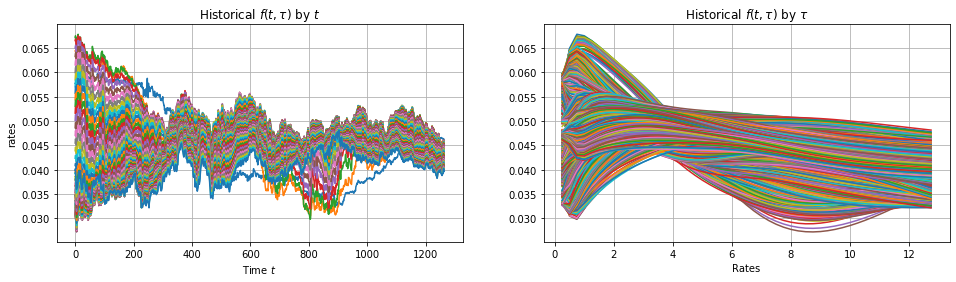

In [4]:
tenors        = [float(x) for x in dataframe.columns]
hist_rates    = np.matrix(dataframe)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist_rates)
plt.xlabel(r'Time $t$ ')
plt.title(r'Historical $f(t,\tau)$ by $t$')
plt.grid(True)
plt.ylabel('rates')

plt.subplot(122)
plt.plot(tenors, hist_rates.transpose())
plt.xlabel(r'Tenor $\tau$') 
plt.title(r'Historical $f(t,\tau)$ by $\tau$')
plt.grid(True)
plt.xlabel('Rates')
plt.show()

### Write our data set into a DataFrame

In [5]:
hist_rates = np.matrix(dataframe)
diff_rates = np.diff(hist_rates, axis=0)
std_of_Diff= diff_rates.std(axis=0)
size       = diff_rates.std(axis=0).shape[1]
sds        = np.zeros(size)

In [6]:
#np.array(hist_rates[-1,:].flatten())[0]
#np.array(hist_rates[-1].flatten())[0]

In [7]:
for i in range(0,size):
    sds[i] = std_of_Diff[0,i]

daily_hist_vols = pd.DataFrame({'Tenors': tenors, 'Current_cc_FwdRates': np.array(hist_rates[-1,:].flatten())[0]}, \
                               columns=['Tenors', 'Current_cc_FwdRates'])
Annual_hist_vols = pd.DataFrame({'Tenors': tenors, 'Current_cc_FwdRates': np.array(hist_rates[-1,:].flatten())[0]}, \
                               columns=['Tenors', 'Current_cc_FwdRates'])

### Write the PCFactor class to calculate Volatility Factors

In [8]:
class PrincipalComponentFactors(object):
    def __init__(self, dataframe):
        self.tenors     = [float(x) for x in dataframe.columns]
        hist_rates      = np.matrix(dataframe)
        self.diff_rates = np.diff(hist_rates, axis=0)
        
        print("Data shape : " + str(self.diff_rates.shape))
        #Calculate covariance matrix

        self.sigma = np.cov(self.diff_rates.transpose())
        print("Variance Covariance shape : " + str(self.sigma.shape))

        # Calculate eigenvalues and eigenvectors
        evals, evecs = la.eig(self.sigma)
        self.evecs   = np.matrix(evecs)

        # check the shapes
        print("eigvalue  shape : " + str(evals.shape))
        print("eigvector shape : " + str(evecs.shape))

        # Determine the largest three principal components
        factors = 3
        index_evecs     = list(reversed(np.real(evals).argsort()))[0:factors]
        self.princ_evals= np.array([evals[i] for i in index_evecs])
        princ_comp      = np.hstack([self.evecs[:,i] for i in index_evecs])
        self.princ_comp = np.real(princ_comp)
        # check the shapes
        print("PC shape : " + str(self.princ_comp.shape))
        
    def VolatilityFactors(self):        
        '''First we take the square root of the three largest eigenvalues and 
        then we multiply them by the largest three principal components'''
        sqrt_evals         = np.matrix(self.princ_evals ** .5)
        tmp_m              = np.vstack([sqrt_evals for i in range(self.princ_comp.shape[0])]) 
        self.daily_factors = np.multiply(np.real(tmp_m), self.princ_comp)
        self.annual_factors= self.daily_factors * np.sqrt(256)
        
        v1                 = np.array(self.daily_factors[:,0].flatten())[0]
        v2                 = np.array(self.daily_factors[:,1].flatten())[0]
        v3                 = np.array(self.daily_factors[:,2].flatten())[0]
        
        # Take the square to calculate the daily volatility
        self.daily_vols = np.sqrt(v1**2 + v2**2 + v3**2)
        # Multiply by sqrt of 252 to calculate the annual volatility
        self.ann_vols   = (self.daily_vols) *np.sqrt(256)
        
        '''self.daily_vols = np.sqrt(np.multiply(self.daily_PC[:,0],self.daily_PC[:,0])+\
                                  np.multiply(self.daily_PC[:,1],self.daily_PC[:,1]) + \
                                  np.multiply(self.daily_PC[:,2],self.daily_PC[:,2]))
        self.ann_vols   = (self.daily_vols)*np.sqrt(252)'''
        
        print('daily vols shape: ' + str(self.daily_vols.shape))   
       
    def PlotPC(self):
        # Print Principal Components
        plt.figure(figsize=(10,4))
        plt.plot(self.tenors, self.princ_comp, marker='.'), plt.title('Principal components'), plt.xlabel(r'Tenor $\tau$');
        plt.grid(True)
        plt.show()
        
    def PlotVF(self):
        # Print Daily Volatility Factor. We prefer to print the daily factors as this preserves the factor's sign
        plt.figure(figsize=(10,4))
        plt.plot(self.tenors, self.daily_factors, marker='.'), \
        plt.title('Daily Volatility Factors'), \
        plt.xlabel(r'Tenor $\tau$'), plt.ylabel(r'Daily Volatility $\sigma$');
        plt.grid(True)
        plt.show()

### Calculate Historical (annual and daily) Volatility Factors of the daily difference of forward rates¶

In [9]:
PCA = PrincipalComponentFactors(dataframe)
PCA.VolatilityFactors()

Data shape : (1263, 51)
Variance Covariance shape : (51, 51)
eigvalue  shape : (51,)
eigvector shape : (51, 51)
PC shape : (51, 3)
daily vols shape: (51,)


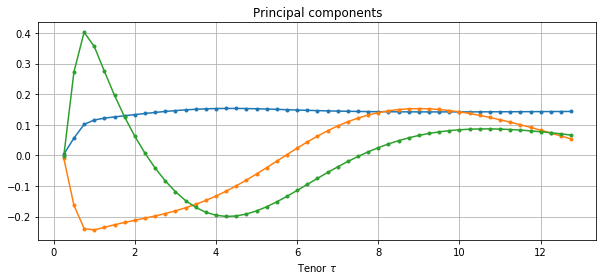

In [10]:
PCA.PlotPC()

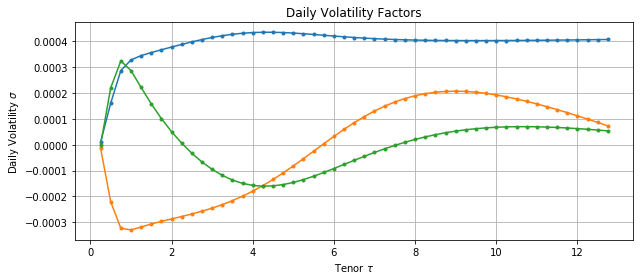

In [11]:
PCA.PlotVF()

In [12]:
daily_hist_vols['Factor_1_Daily'] = PCA.daily_factors[:,0]
daily_hist_vols['Factor_2_Daily'] = PCA.daily_factors[:,1]
daily_hist_vols['Factor_3_Daily'] = PCA.daily_factors[:,2]

Annual_hist_vols['Factor_1'] = PCA.annual_factors[:,0]
Annual_hist_vols['Factor_2'] = PCA.annual_factors[:,1]
Annual_hist_vols['Factor_3'] = PCA.annual_factors[:,2]

In [13]:
daily_hist_vols['PCA_Factors_Daily_Vol']   = PCA.daily_vols
Annual_hist_vols['PCA_Factors_Annual_Vol'] = PCA.ann_vols

daily_hist_vols['Hist_Daily_Vol']   = sds
Annual_hist_vols['Hist_Annual_Vol'] = sds*np.sqrt(256)

#### The Daily Volatility Factor DataFrame

In [14]:
daily_hist_vols.head()

,Tenors,Current_cc_FwdRates,Factor_1_Daily,Factor_2_Daily,Factor_3_Daily,PCA_Factors_Daily_Vol,Hist_Daily_Vol
0,0.25,0.046138,0.000010,-0.000013,-8.986680e-07,0.000017,0.000396
1,0.50,0.045251,0.000161,-0.000221,2.201285e-04,0.000351,0.000503
2,0.75,0.042916,0.000287,-0.000324,3.241624e-04,0.000541,0.000568
3,1.00,0.042833,0.000328,-0.000330,2.867562e-04,0.000547,0.000565
4,1.25,0.043498,0.000345,-0.000319,2.214218e-04,0.000519,0.000534


#### The Annual Volatility Factor DataFrame

In [15]:
Annual_hist_vols.head()

,Tenors,Current_cc_FwdRates,Factor_1,Factor_2,Factor_3,PCA_Factors_Annual_Vol,Hist_Annual_Vol
0,0.25,0.046138,0.000159,-0.000211,-0.000014,0.000265,0.006330
1,0.50,0.045251,0.002572,-0.003540,0.003522,0.005617,0.008045
2,0.75,0.042916,0.004592,-0.005181,0.005187,0.008650,0.009092
3,1.00,0.042833,0.005250,-0.005279,0.004588,0.008745,0.009034
4,1.25,0.043498,0.005518,-0.005098,0.003543,0.008306,0.008543


### How well have Volatility Factors captured the historical volatility of forward rates?

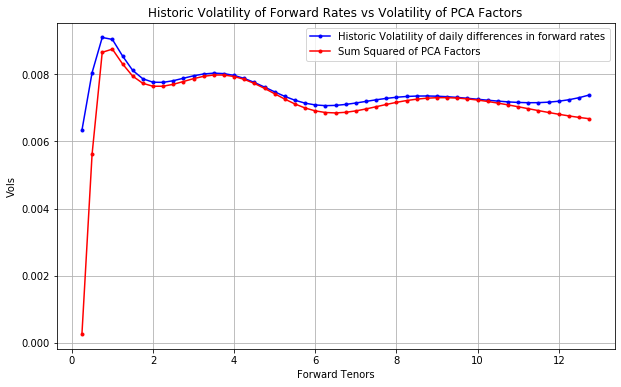

In [16]:
plt.figure(figsize=(10,6))
plt.plot(Annual_hist_vols.Tenors, Annual_hist_vols.Hist_Annual_Vol, marker='.', lw=1.5, \
         color='blue', label ='Historic Volatility of daily differences in forward rates' )
plt.plot(Annual_hist_vols.Tenors, Annual_hist_vols.PCA_Factors_Annual_Vol, marker='.', lw=1.5,  \
         color='red', label ='Sum Squared of PCA Factors')
plt.legend()
plt.xlabel('Forward Tenors')  
plt.ylabel('Vols')
plt.grid(True)
plt.title("Historic Volatility of Forward Rates vs Volatility of PCA Factors");
plt.show()

### Write Interpolation classes
##### We have to be able to fit the points of Volatility Factors. We may also want to interpolate between points in case we need a much granular data set to work with. 
##### In this workbook we will ony use the two PolyInterpolator classes

In [17]:
from scipy.interpolate import splrep, splev
from scipy.interpolate import interp1d

class Interpolator(object):
    def __init__(self, x1, y1):
        self.x1 = x1
        self.y1 = y1
    def fitting(self,x):
        pass
    
class SplineInterpolator(Interpolator):
    def fitting(self,x):
        ret = splrep(self.x1, self.y1)
        return splev(x, ret)

class QuadraticInterpolator(Interpolator):
    def __init__(self, x1, y1):    
        self.fq = interp1d(x1, y1, kind='quadratic')                   
                       
    def fitting(self,x):        
        return self.fq(x)

class PolyInterpolatorDegree3(Interpolator):
    def __init__(self, x1, y1):    
        self.fq = np.polyfit(x1,y1,3)                   
                                   
    def fitting(self,x):        
        ynew = np.poly1d(self.fq)
        return ynew(x)

class PolyInterpolatorDegree0(Interpolator):
    def __init__(self, x1, y1):    
        self.fq = np.polyfit(x1,y1,0)                   
                                   
    def fitting(self,x):        
        ynew = np.poly1d(self.fq)
        return ynew(x)

#### Let's see how good we can interpolate with Polynomial of degree 0 (an average) for the first component (which is the level of changes in forward rates) and of degree 3 for the second and third component

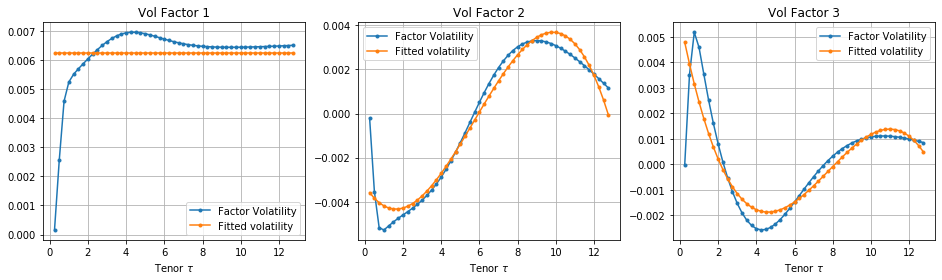

In [18]:
VolatilityFactors = []
def FittingVolatilityFactors(i, tenors, vol):
    if(i == 0): fitted_volPoly = PolyInterpolatorDegree0(tenors, vol) 
    else:       fitted_volPoly = PolyInterpolatorDegree3(tenors, vol)    
    return fitted_volPoly

def Return_column_Index(mat, i):
    return np.array(mat[:,i].flatten())[0]

def PlottingVolatilityFactors(i, title):
    vol    = PCA.annual_factors
    vol    = Return_column_Index(vol, i)
    tenors = PCA.tenors
    
    fitted_volPoly = FittingVolatilityFactors(i, tenors, vol)
    plt.plot(tenors, vol, marker='.', label='Factor Volatility')    
    plt.plot(tenors, [fitted_volPoly.fitting(x) for x in tenors], marker='.', label='Fitted volatility')
    plt.grid(True)
    plt.title(title), plt.xlabel(r'Tenor $\tau$'), plt.legend();
    VolatilityFactors.append(fitted_volPoly)
    
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1), PlottingVolatilityFactors(0,  'Vol Factor 1');
plt.subplot(1, 3, 2), PlottingVolatilityFactors(1,  'Vol Factor 2');
plt.subplot(1, 3, 3), PlottingVolatilityFactors(2,  'Vol Factor 3');

#### Let's plot the Volatility Factors all together

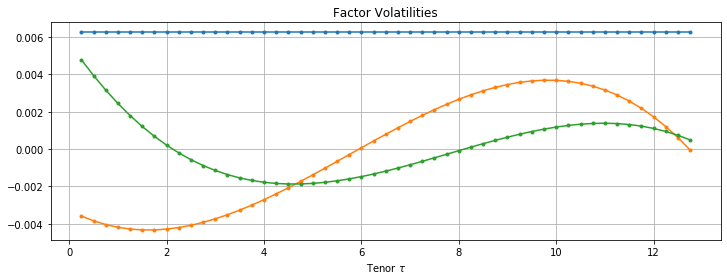

In [19]:
plt.figure(figsize=(12,4))
#x_tenors = np.linspace(0,25,50*2 + 1)
x_tenors = np.linspace(0.25,12.75,51)
y_vols    = np.matrix([[fitted_vol.fitting(tenor) for tenor in x_tenors] for fitted_vol in VolatilityFactors]).transpose()
plt.plot(x_tenors, y_vols, marker='.'), plt.xlabel(r'Tenor $\tau$'), plt.title('Factor Volatilities'), plt.grid(True);

In [20]:
x_tenors

array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
        4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,
        7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
        9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
       11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75])

In [21]:
y_vols.shape

(51, 3)

### Write the Drift object
#### We can now build the drift object which takes in the Volatility Factors we have just fitted

$$ m(t,\tau) = \sum_{i=1}^3 VolFactor_i(t,\tau) \int_0^\tau VolFactor_i(t,s)ds $$

In [22]:
from scipy.integrate import quad
def Integration(f, x):
    numer = lambda s: f(s) 
    return quad(numer, 0, x)[0]

def m(tau, VolatilityFactors):
    out = 0.
    for fitted_vol in VolatilityFactors:
        out += fitted_vol.fitting(tau) * Integration(fitted_vol.fitting, tau)
    return out

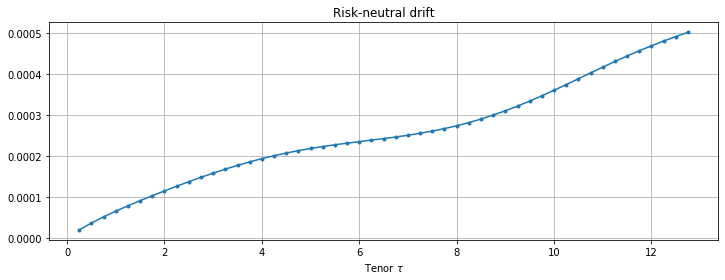

In [23]:
m_drift = np.array([m(tau, VolatilityFactors) for tau in x_tenors])

plt.figure(figsize=(12,4))
plt.plot(x_tenors, m_drift, marker='.'), plt.xlabel(r'Tenor $\tau$'), plt.title('Risk-neutral drift'), plt.grid(True);

In [24]:
m_drift.shape

(51,)

### Interpolate Forward rates, a detour as we do not really need in this notebook 
#### Look again at our forward rates. 
#### The first rate has a maturity of 3 month and it is the 3 month spot rate. The second is the forward in 6 months for a maturity of 3 months (so we have 6 months)....
#### We may want to have a more granular data set, so we interpolate

In [25]:
Annual_hist_vols.head(3)

,Tenors,Current_cc_FwdRates,Factor_1,Factor_2,Factor_3,PCA_Factors_Annual_Vol,Hist_Annual_Vol
0,0.25,0.046138,0.000159,-0.000211,-0.000014,0.000265,0.006330
1,0.50,0.045251,0.002572,-0.003540,0.003522,0.005617,0.008045
2,0.75,0.042916,0.004592,-0.005181,0.005187,0.008650,0.009092


[0.25  0.375 0.5  ]


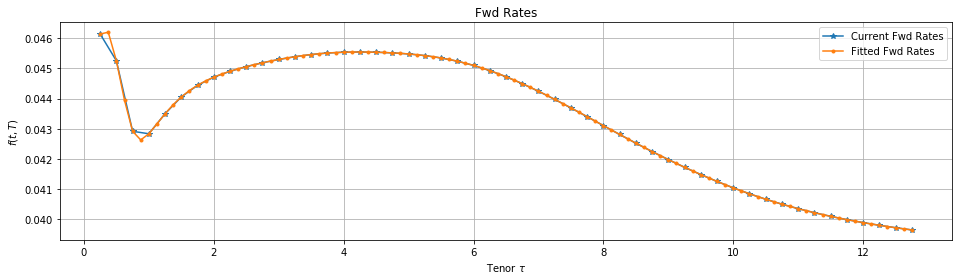

In [26]:
xx_tenors = np.linspace(0.25,12.75,101)
print (xx_tenors[0:3])
def FittingRates(x, tenors, Rates):
    fitted_rates = SplineInterpolator(tenors, Rates) 
    return fitted_rates.fitting(x)

FittedFwdRates = [FittingRates(x, Annual_hist_vols.Tenors, Annual_hist_vols.Current_cc_FwdRates) for x in xx_tenors]

plt.figure(figsize=(16,4))
plt.plot(Annual_hist_vols.Tenors, Annual_hist_vols.Current_cc_FwdRates, marker='*', label='Current Fwd Rates')    
plt.plot(xx_tenors, FittedFwdRates, marker='.', label='Fitted Fwd Rates')
plt.xlabel(r'Tenor $\tau$')
plt.ylabel('$f(t,T)$')
plt.title('Fwd Rates')
plt.grid(True)
plt.legend();

But these are our tenors!!

In [27]:
x_tenors

array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
        4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,
        7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
        9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
       11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75])

### Let's create our HJM class
#### The class has only two methods: OneSimulation to prepare one simulation, and ManySimulations to run as many as it is requested 

In [28]:
class HJM(object):
    def __init__(self, Tenors, ForwardRates, Drifts, FactorVolatilities):
        self.Tenors             = Tenors
        self.ForwardRates       = ForwardRates
        self.Drifts             = Drifts
        self.FactorVolatilities = FactorVolatilities
        
    def OneSimulation(self, dt, Maturity):
        
        No_time_Steps       = int(float(Maturity)/float(dt))
        No_Tenors           = len(self.ForwardRates)        
        No_Vols             = self.FactorVolatilities.shape[1]   
        sqrt_dt             = np.sqrt(dt)
        
        self.Output         = np.zeros((No_Tenors, No_time_Steps+1))
        
        self.Output[:, 0]   = self.ForwardRates
        fprev               = self.ForwardRates
        fnew                = np.zeros(No_Tenors)
               
        for i in range(0, No_time_Steps):
            
            fnew = fprev + self.Drifts * dt 
            
            z    = npr.standard_normal(No_Vols)
            Vol  = np.dot(self.FactorVolatilities, z.T)
            Vol  = np.array(Vol.flatten())[0]
            Vol  *= sqrt_dt                                                
            
            fnew += Vol
            
            FF  = np.diff(fprev, axis=0)
            FF  = np.append(FF, FF[-1])
            FF  /= (self.Tenors[2] - self.Tenors[1]) # First Derivative
            
            FF *= dt
            
            fnew += FF
            
            fprev = fnew            
            self.Output[:, i + 1] = fnew
                
    def ManySimulations(self, dt, Maturity, NoSimulation):
        
        No_time_Steps       = int(float(Maturity)/float(dt))
        No_Tenors           = len(self.ForwardRates)        
        
        self.ManyOutputs    = np.zeros((No_Tenors, No_time_Steps+1, NoSimulation))
               
        for i in range(0, NoSimulation):
            self.OneSimulation(dt, Maturity)
            self.ManyOutputs[:,:,i] = self.Output

### Simulations

#### We have forward rates, volatility factors and drifts all set up at the same time steps. 
#### Let's run our first simulation over the next day

In [29]:
Maturity = 1/256.0
dt       = 1/256.0

# So we always use the same random numbers
npr.seed(1500)

# Current Forward Rates
InitialRates = Annual_hist_vols.Current_cc_FwdRates

# Instantiate an object of class HJM   
hjm = HJM(x_tenors, InitialRates, m_drift, y_vols)

# Run method OneSimulation() which simulates forward rates after one day 
hjm.OneSimulation(dt, Maturity)

print(InitialRates[0:5])
# The first column includes the forward rates at t = 0 (today), the second the forward rates after one day. 
# We only print the first 5 tenors
hjm.Output[0:5,:]                           

0    0.046138
1    0.045251
2    0.042916
3    0.042833
4    0.043498
Name: Current_cc_FwdRates, dtype: float64


array([[0.04613836, 0.04595692],
       [0.04525117, 0.04500126],
       [0.04291581, 0.04265994],
       [0.04283311, 0.04255232],
       [0.04349772, 0.04318298]])

#### Two simulations over the next day

In [30]:
# The same random numbers
npr.seed(1500) 

# Run method ManySimulations() which runs twice OneSimulation() and simulates twice forward rates after one day
hjm.ManySimulations(dt, Maturity, 2)

# and let's print the outcomes for the first 5 tenors
print (hjm.ManyOutputs[0:5,:,0]) # the same as before, as we used the same random number
print ( " ------------------------ ")
print (hjm.ManyOutputs[0:5,:,1]) # ..and a new output of forward rates

[[0.04613836 0.04595692]
 [0.04525117 0.04500126]
 [0.04291581 0.04265994]
 [0.04283311 0.04255232]
 [0.04349772 0.04318298]]
 ------------------------ 
[[0.04613836 0.04694457]
 [0.04525117 0.04600799]
 [0.04291581 0.04367916]
 [0.04283311 0.04357775]
 [0.04349772 0.04420868]]


### We are ready to price a Zero Coupon Bond Option 
#### We can simulate forward rates at any future date, so that we are able to calculate the future discount factors and the corresponding value of a Zero Coupon Bond
#### With the value of the Zero Coupon Bond we can calculate the option payoff at the option maturity
#### As we have the forward rates at any future date we can also discount the payoff back to today and so calculate the option price
#### We set the option maturity at year three at a strike of 0.9. The underying ZCB matures in six years from now, so at the option maturity the bond has a remaining maturity of three years 

In [31]:
# We only need these tenors, as the option matures at year 3!
x_tenors[0:12]

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  ])

In [32]:
# So we always use the same random numbers
npr.seed(1500)

OptionMaturity = 3
Strike         = 0.90
ZCBMaturity    = 6
dt             = 1/256.0
NoSim          = 1000

# An object of class HJM   
hjm = HJM(x_tenors[0:12], FittedFwdRates[0:12], m_drift[0:12], y_vols[0:12])

# Run method ManySimulations()
hjm.ManySimulations(dt, OptionMaturity, NoSim)

### Plot some simulated Forward Rates

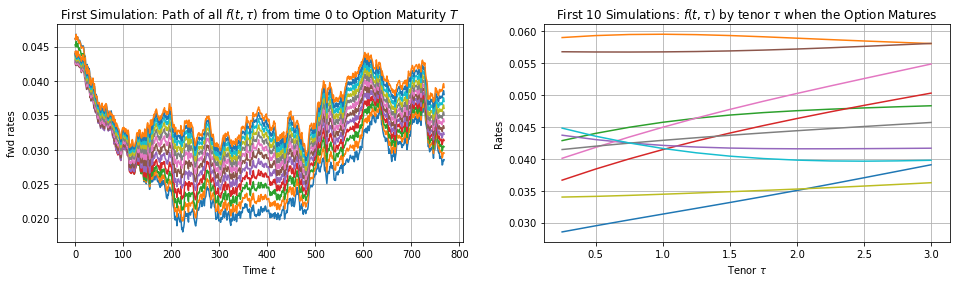

In [33]:
ratesToPlot1 = hjm.ManyOutputs[:,:,0]    # First Simulation all tenors over time
ratesToPlot2 = hjm.ManyOutputs[:,-1,0:10]# N Simulations for all tenors when the option matures

ratesToPlot1    = np.matrix(ratesToPlot1)
ratesToPlot1    = ratesToPlot1.T
tenorsPlot2  = x_tenors[0:12]

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(ratesToPlot1)
plt.xlabel(r'Time $t$ ')
plt.title(r'First Simulation: Path of all $f(t,\tau)$ from time 0 to Option Maturity $T$')
plt.grid(True)
plt.ylabel('fwd rates')

plt.subplot(122)
plt.plot(tenorsPlot2, ratesToPlot2)
plt.xlabel(r'Tenor $\tau$') 
plt.title(r'First 10 Simulations: $f(t,\tau)$ by tenor $\tau$ when the Option Matures')
plt.grid(True)
plt.ylabel('Rates')
plt.show()

#### We need functions to price the ZCB from DFs

In [34]:
def ZCB(FwdRates):    
    # we assume rates are on a 3-month basis
    size = len(np.zeros(len(FwdRates)))
    
    # Prerare the forward discount factors    
    FDFs = np.exp(-FwdRates*0.25)
    
    # Prepare the spot discount factors
    DFs = np.cumprod(FDFs)
    
    # and return the Value of a ZCB
    return DFs[-1]

### We price the option now
#### For each simulation, we calculate
    1 the payoff at the option at maturity
    2 the discounted value of the Payoff. For the discounted payoff we use the rate with a tenor 0.25

In [35]:
PayoffValues     = np.zeros(NoSim) 
DiscountedValues = np.zeros(NoSim)
for i in range(NoSim):
    
    # 1. We collect the forward rates at the last day of the simulation
    rates = hjm.ManyOutputs[:,-1,i]
    
    # 2. From the forward rates we calculate the discount factors and from them the value of the ZCB with a remaining
    # maturity of three years
    ZCBPrice = ZCB(rates)
    
    # 3. The option payoff at the option maturity
    Payoff   = (np.maximum(ZCBPrice - Strike,0))
    
    # As we have the forward rates path to arrive at the option maturity, we can also use to calculate discounted
    # value of the payoff. The rate that we use is the rate with a 0.25 tenor 
    Discount = np.exp(-np.sum(hjm.ManyOutputs[0,0:-1,i])*dt)
    Value    = Payoff*Discount
    
    PayoffValues[i]     = Payoff 
    DiscountedValues[i] = Value 

# Price per $100 of notional
print("the price of the option is ", np.round(np.mean(DiscountedValues) *100,4)) 

the price of the option is  0.3532


We collect the forward rates when the option matures from the last simulation

In [36]:
Rates_on_last_Simulation = hjm.ManyOutputs[:,-1,-1]
ForwardRateToPrice = pd.DataFrame({'Tenors': tenors[0:12], 'FwdRates_At_OptionMat': np.array(Rates_on_last_Simulation)}, \
                                  columns=['Tenors', 'FwdRates_At_OptionMat'])
print(ForwardRateToPrice)   

    Tenors  FwdRates_At_OptionMat
0     0.25               0.033352
1     0.50               0.034089
2     0.75               0.034739
3     1.00               0.035300
4     1.25               0.035781
5     1.50               0.036191
6     1.75               0.036545
7     2.00               0.036860
8     2.25               0.037153
9     2.50               0.037438
10    2.75               0.037725
11    3.00               0.038017
